In [1]:
#@title Set up lama
print('\n> Cloning the repo')
!git clone https://github.com/saic-mdal/lama.git

print('\n> Install dependencies')
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 torchtext==0.9
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet

print('\n> Changing the dir to:')
%cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip -o big-lama.zip

print('>fixing opencv')
!pip uninstall opencv-python-headless opencv-contrib-python-headless opencv-python opencv-contrib-python -y --quiet
!pip install opencv-contrib-python-headless==4.1.2.30 --quiet



> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 367, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 367 (delta 16), reused 23 (delta 8), pack-reused 332
Receiving objects: 100% (367/367), 9.88 MiB | 18.63 MiB/s, done.
Resolving deltas: 100% (113/113), done.

> Install dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 735.5 MB 13 kB/s 
     |████████████████████████████████| 17.3 MB 8.1 MB/s 
     |████████████████████████████████| 1.9 MB 56.6 MB/s 
     |████████████████████████████████| 7.1 MB 24.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.1

In [4]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


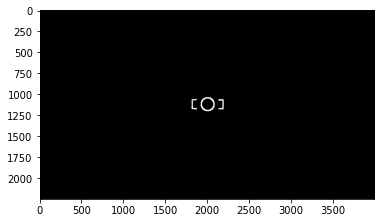

In [58]:
#@title Prepair Mask
import cv2
import numpy as np
from matplotlib import pyplot as plt

import math, os

im = cv2.imread('/content/drive/MyDrive/inpainting/screen.jpg', 0)

im = 255-im

# # グレースケール画像を白黒に変換
# ret_, bw_img = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# # 白黒画像の輪郭を抽出
# contours, h_ = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

# # 輪郭からバンディングボックスを計算
# rect = cv2.boundingRect(contours[-1])

# # バウンディングボックスの座標で元画像をクロップ
# crop_img = im[rect[1]:rect[1]+rect[3]-1, rect[0]:rect[0]+rect[2]-1]

# crop_img = 255 - crop_img

length_threshold = 10
distance_threshold = 1.41421356
canny_th1 = 50
canny_th2 = 50
canny_aperture_size = 3
do_merge = False

fld = cv2.ximgproc.createFastLineDetector(
    length_threshold,
    distance_threshold,
    canny_th1,
    canny_th2,
    canny_aperture_size,
    do_merge
)

# blank = np.full(crop_img.shape[:2], 255, dtype=crop_img.dtype)
# lines = fld.detect(crop_img)

blank = np.full(im.shape[:2], 255, dtype=im.dtype)
lines = fld.detect(im)
line_drawing = fld.drawSegments(blank, lines)
line_drawing = cv2.cvtColor(line_drawing, cv2.COLOR_BGR2GRAY)

ret, img_thresh = cv2.threshold(line_drawing, 200, 255, cv2.THRESH_BINARY)

img_thresh = 255 - img_thresh

dilation = cv2.dilate(img_thresh,np.ones((5,5),np.uint8),iterations = 3)
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))

h,w=closing.shape[:2]
mask=np.zeros((h,w),dtype=np.uint8)
cv2.circle(mask,center=(int(w/2),int(h/2)),radius=400,color=255,thickness=-1)

closing[mask==0] = 0

cv2.imwrite('/content/drive/MyDrive/inpainting/mask.png', closing)

plt.imshow(cv2.cvtColor(closing, cv2.COLOR_BGR2RGB))
plt.show()

In [61]:
#@title Trim & Convert

# def trim_image(im):
#   imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
#   imgray = cv2.blur(imgray,(15,15))
#   ret,thresh = cv2.threshold(imgray,math.floor(np.average(imgray)),255,cv2.THRESH_BINARY_INV)
#   dilated=cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10)))
#   contours,_ = cv2.findContours(dilated,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

#   new_contours=[]
#   for c in contours:
#       if cv2.contourArea(c)<4000000:
#           new_contours.append(c)
          
#   box=[-1,-1,-1,-1]
#   for c in new_contours:
#     x,y,w,h = cv2.boundingRect(c)
#     if box[0] < 0:
#         box=[x,y,x+w,y+h]
#     else:
#         if x<box[0]:
#             box[0]=x
#         if y<box[1]:
#             box[1]=y
#         if x+w>box[2]:
#             box[2]=x+w
#         if y+h>box[3]:
#             box[3]=y+h
            
#   return im[box[1]:box[3], box[0]:box[2]]

def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

paths = list_full_paths(r'/content/drive/MyDrive/inpainting/input/')

for path in paths:
  print(path)
  im = cv2.imread(path)
  png_path = f'{os.path.splitext(path)[0]}.png'
  # im = trim_image(im)
  cv2.imwrite(png_path, im)
  # Resize Mask Image
  mask = cv2.imread('/content/drive/MyDrive/inpainting/mask.png', 0)
  mask = cv2.resize(mask, dsize=tuple(sorted(im.shape[:2],reverse=True)))
  mask_path = f'{os.path.splitext(path)[0]}_mask.png'
  cv2.imwrite(mask_path, mask)
  # 確認用
  # img_or = cv2.bitwise_or(im, cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR))
  # path_or = f'{os.path.splitext(path)[0]}_or.png'
  # cv2.imwrite(path_or, img_or)

/content/drive/MyDrive/inpainting/input/CENTER_0001_BURST20221105133345801_COVER.JPG
/content/drive/MyDrive/inpainting/input/CENTER_0001_BURST20221105133345801_COVER.png
/content/drive/MyDrive/inpainting/input/CENTER_0001_BURST20221105133345801_COVER_mask.png


In [63]:
#@title Inpainting

!python3 bin/predict.py model.path=$(pwd)/big-lama indir=/content/drive/MyDrive/inpainting/input outdir=/content/drive/MyDrive/inpainting/output

Detectron v2 is not installed
[2022-11-05 04:54:08,575][saicinpainting.utils][WARNING] - Setting signal 10 handler <function print_traceback_handler at 0x7f8f5c99f830>
[2022-11-05 04:54:08,602][root][INFO] - Make training model default
[2022-11-05 04:54:08,602][saicinpainting.training.trainers.base][INFO] - BaseInpaintingTrainingModule init called
[2022-11-05 04:54:08,602][root][INFO] - Make generator ffc_resnet
[2022-11-05 04:54:09,059][saicinpainting.training.trainers.base][INFO] - Generator
FFCResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): FFC_BN_ACT(
      (ffc): FFC(
        (convl2l): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), bias=False, padding_mode=reflect)
        (convl2g): Identity()
        (convg2l): Identity()
        (convg2g): Identity()
        (gate): Identity()
      )
      (bn_l): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_g): Identity()
      (act_l): ReLU(inplace=True)


In [ ]:
# __dir__ = os.path.dirname(os.path.abspath(__file__))
# sys.path.append(__dir__)
# sys.path.append(os.path.abspath(os.path.join(__dir__, '../')))